In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, QiskitError
#from qiskit import execute, BasicAer
import qiskit.ignis.verification.randomized_benchmarking as rb
#import qiskit.test.benchmarks.randomized_benchmarking as br
import pyzx
from pyzx.circuit.qasmparser import QASMParser
from pyzx.circuit.qiskitqasmparser import QiskitQASMParser

In [2]:
#qc = rb.randomized_benchmarking_seq()
# qc = rb.randomized_benchmarking_seq(nseeds=1, length_vector=None,
#                                 rb_pattern=[[0,1]],
#                                 length_multiplier=1, seed_offset=0,
#                                 align_cliffs=False,
#                                 interleaved_gates=None,
#                                 is_purity=False)
# qc = qc[0][0][0]

qr0 = QuantumRegister(3, 'qr0')
qr1 = QuantumRegister(2, 'qr1')
qr2 = QuantumRegister(1, 'qr2')
qr3 = QuantumRegister(6, 'qr3')
cr0 = ClassicalRegister(2, 'cr0')
cr1 = ClassicalRegister(3, 'cr1')
qc = QuantumCircuit(qr3, qr1, qr0, qr2, cr0, cr1)
qc.x(8)
qc.h(2)
qc.cx(4,5)


In [3]:
# setting up the backend
# print(BasicAer.backends())

# running the job
# job_sim = execute(qc, BasicAer.get_backend('qasm_simulator'))
# sim_result = job_sim.result()

In [4]:
# print("\nPrint all gates:")
# [print(dat) for dat in qc.data]

In [5]:
qasm = qc.qasm()
#qasm = '\n'.join(['' if line.startswith("barrier") else line for line in qasm.splitlines()])

print("\nPrint QASM:")
print(qasm)




Print QASM:
OPENQASM 2.0;
include "qelib1.inc";
qreg qr3[6];
qreg qr1[2];
qreg qr0[3];
qreg qr2[1];
creg cr0[2];
creg cr1[3];
x qr0[0];
h qr3[2];
cx qr3[4],qr3[5];



In [6]:
# Draw the circuit
print(qc)

               
qr3_0: |0>─────
               
qr3_1: |0>─────
          ┌───┐
qr3_2: |0>┤ H ├
          └───┘
qr3_3: |0>─────
               
qr3_4: |0>──■──
          ┌─┴─┐
qr3_5: |0>┤ X ├
          └───┘
qr1_0: |0>─────
               
qr1_1: |0>─────
          ┌───┐
qr0_0: |0>┤ X ├
          └───┘
qr0_1: |0>─────
               
qr0_2: |0>─────
               
qr2_0: |0>─────
               
 cr0_0: 0 ═════
               
 cr0_1: 0 ═════
               
 cr1_0: 0 ═════
               
 cr1_1: 0 ═════
               
 cr1_2: 0 ═════
               


In [7]:
p = QiskitQASMParser()
circ_list, whichpyzx = p.qiskitparse(qasm)
# print(circ_list)
# print(whichpyzx)

# from numpy.random import permutation
# perm = permutation(list(p.registers.items()))
# print(perm)
# print(sorted(perm, key=lambda x: x[1][0]))

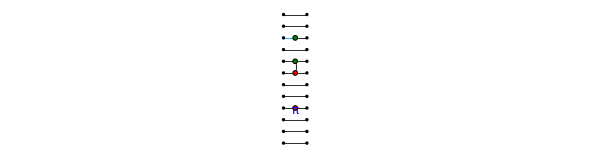

In [8]:
#qasm = qc.decompose().qasm()
pyzx.draw_many(circ_list, whichpyzx)


#print(circ_list)
#print(len(circ_list))
#print(whichpyzx)
# whichplt = 0
# for i in range(len(circ_list)):
#     if isinstance(circ_list[i], str):
#         pass
#     else:
#         circ_list[i].name = "pyzx_" + qc.name + "_" + str(i)
#         plt.axes(axs[whichplt])
#         fig = pyzx.draw(circ_list[i])
#         break
#plt.show()
#c.name = "pyzx_" + qc.name
#pyzx.draw(c)
#pyzx.draw(c.to_graph(), layout=None, labels=False, figsize=(16,4), h_edge_draw='blue', rows=None)

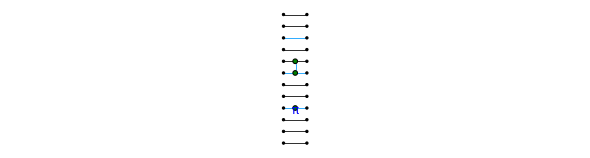

In [9]:
graph_list = [circ_list[w].to_graph() for w in whichpyzx]
[pyzx.full_reduce(g) for g in graph_list]

#graph_list[0].normalise()

pyzx.draw_many(graph_list, range(len(whichpyzx)))

In [10]:
pyzx_circ_list = [pyzx.extract.streaming_extract(g) for g in graph_list]

for i in range(len(pyzx_circ_list)):
    prev = pyzx_circ_list[i]
    next = pyzx.extract.streaming_extract(graph_list[i])
    while prev.gates != next.gates:
        for j in range(len(next.gates))[::-1]:
            pyzx_circ_list[i].add_gate_to_front(next.gates[j])
        prev = next
        next = pyzx.extract.streaming_extract(graph_list[i])

pyzx_circ_list = [pyzx.optimize.basic_optimization(new_c.to_basic_gates()) for new_c in pyzx_circ_list]

pyzx_qasm = [new_c.to_basic_gates().to_qasm() for new_c in pyzx_circ_list]

pyzx_qasm = ["\n".join(['' if line.startswith("qreg") else line for line in circ.splitlines()[2:]]) for circ in pyzx_qasm]

for new_qasm in pyzx_qasm:
    [print(line) for line in new_qasm.splitlines()]
    print()


h q[2];
cx q[4], q[5];
x q[8];



In [11]:
#now we need to map registers and glue all the pieces back together
for i in range(len(pyzx_qasm)):
    circ_list[whichpyzx[i]] = pyzx_qasm[i]
#print(circ_list)
## join the
qasm_string = 'OPENQASM 2.0;\ninclude "qelib1.inc";\n'+"\n".join(circ_list)
print(qasm_string)

OPENQASM 2.0;
include "qelib1.inc";
qreg qr3[6];
qreg qr1[2];
qreg qr0[3];
qreg qr2[1];
creg cr0[2];
creg cr1[3];

h q[2];
cx q[4], q[5];
x q[8];


In [12]:
sorted_registers = sorted(p.registers.items(), key=lambda x: x[1][0])
print(sorted_registers)

import re
from re import finditer
poss = [m.start() for m in re.finditer('q\[', qasm_string)]
registered_qasm = ''
prev_pos = 0
for pos in poss:
    registered_qasm += qasm_string[prev_pos:pos]
    prev_pos = pos+qasm_string[pos:].find(']')
    id = int(qasm_string[pos+2:prev_pos])
    leq_list = list(filter(lambda x: (x[1][0] <= id), sorted_registers))
    registered_qasm += leq_list[-1][0] + '[' + str(id - leq_list[-1][1][0])
registered_qasm += qasm_string[prev_pos:]
print(registered_qasm)


[('qr3', (0, 6)), ('qr1', (6, 2)), ('qr0', (8, 3)), ('qr2', (11, 1))]
OPENQASM 2.0;
include "qelib1.inc";
qreg qr3[6];
qreg qr1[2];
qreg qr0[3];
qreg qr2[1];
creg cr0[2];
creg cr1[3];

h qr3[2];
cx qr3[4], qr3[5];
x qr0[0];


In [13]:
# pqsl = [line + "\n" for line in pyzx_qasm] #took out .splitlines()
# qsl = [line + "\n" for line in qasm.splitlines()]
# # print(pqsl)
# # print(qsl)
# new_qasm = '\n'.join(qsl[0:4]) + ''.join(pqsl[3:]) + ''.join(qsl[-2:])
# new_qasm = new_qasm.replace('q[', 'qr[')
# print(new_qasm)

In [14]:
new_qc = qc.from_qasm_str(registered_qasm)
print(new_qc)

               
qr3_0: |0>─────
               
qr3_1: |0>─────
          ┌───┐
qr3_2: |0>┤ H ├
          └───┘
qr3_3: |0>─────
               
qr3_4: |0>──■──
          ┌─┴─┐
qr3_5: |0>┤ X ├
          └───┘
qr1_0: |0>─────
               
qr1_1: |0>─────
          ┌───┐
qr0_0: |0>┤ X ├
          └───┘
qr0_1: |0>─────
               
qr0_2: |0>─────
               
qr2_0: |0>─────
               
 cr0_0: 0 ═════
               
 cr0_1: 0 ═════
               
 cr1_0: 0 ═════
               
 cr1_1: 0 ═════
               
 cr1_2: 0 ═════
               


In [15]:
print(qc)

               
qr3_0: |0>─────
               
qr3_1: |0>─────
          ┌───┐
qr3_2: |0>┤ H ├
          └───┘
qr3_3: |0>─────
               
qr3_4: |0>──■──
          ┌─┴─┐
qr3_5: |0>┤ X ├
          └───┘
qr1_0: |0>─────
               
qr1_1: |0>─────
          ┌───┐
qr0_0: |0>┤ X ├
          └───┘
qr0_1: |0>─────
               
qr0_2: |0>─────
               
qr2_0: |0>─────
               
 cr0_0: 0 ═════
               
 cr0_1: 0 ═════
               
 cr1_0: 0 ═════
               
 cr1_1: 0 ═════
               
 cr1_2: 0 ═════
               


In [16]:
import qiskit
from qiskit.providers.basicaer import QasmSimulatorPy
c1 = qiskit.execute(qc, QasmSimulatorPy()).result().get_counts()
c2 = qiskit.execute(new_qc, QasmSimulatorPy()).result().get_counts()

No measurements in circuit "circuit0", classical register will remain all zeros.
No measurements in circuit "circuit1", classical register will remain all zeros.


In [17]:
c1

{'000 00': 1024}

In [18]:
c2

{'000 00': 1024}

In [19]:
qc.depth()

1

In [20]:
qc.size()

3

In [21]:
new_qc.depth()

1

In [22]:
new_qc.size()

3

In [23]:
new_new_qc = qiskit.transpile(qc, basis_gates=['u3', 'cx'], optimization_level=2)

In [24]:
print(new_new_qc)

                         
qr3_0: |0>───────────────
                         
qr3_1: |0>───────────────
            ┌──────────┐ 
qr3_2: |0>──┤ U2(0,pi) ├─
            └──────────┘ 
qr3_3: |0>───────────────
                         
qr3_4: |0>───────■───────
               ┌─┴─┐     
qr3_5: |0>─────┤ X ├─────
               └───┘     
qr1_0: |0>───────────────
                         
qr1_1: |0>───────────────
          ┌─────────────┐
qr0_0: |0>┤ U3(pi,0,pi) ├
          └─────────────┘
qr0_1: |0>───────────────
                         
qr0_2: |0>───────────────
                         
qr2_0: |0>───────────────
                         
 cr0_0: 0 ═══════════════
                         
 cr0_1: 0 ═══════════════
                         
 cr1_0: 0 ═══════════════
                         
 cr1_1: 0 ═══════════════
                         
 cr1_2: 0 ═══════════════
                         


In [25]:
new_new_qc.depth()

1

In [26]:
new_new_qc.size()

3

In [27]:
doubly_qc = qiskit.transpile(new_qc, basis_gates=['u3', 'cx'], optimization_level=2)
print(doubly_qc)

                         
qr3_0: |0>───────────────
                         
qr3_1: |0>───────────────
            ┌──────────┐ 
qr3_2: |0>──┤ U2(0,pi) ├─
            └──────────┘ 
qr3_3: |0>───────────────
                         
qr3_4: |0>───────■───────
               ┌─┴─┐     
qr3_5: |0>─────┤ X ├─────
               └───┘     
qr1_0: |0>───────────────
                         
qr1_1: |0>───────────────
          ┌─────────────┐
qr0_0: |0>┤ U3(pi,0,pi) ├
          └─────────────┘
qr0_1: |0>───────────────
                         
qr0_2: |0>───────────────
                         
qr2_0: |0>───────────────
                         
 cr0_0: 0 ═══════════════
                         
 cr0_1: 0 ═══════════════
                         
 cr1_0: 0 ═══════════════
                         
 cr1_1: 0 ═══════════════
                         
 cr1_2: 0 ═══════════════
                         


In [28]:
doubly_qc.depth()

1

In [29]:
doubly_qc.size()

3